## LIBRARIES  :

In [36]:
# download the dependencies :
!pip install -q transformers datasets torch accelerate evaluate scikit-learn




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import accuracy_score , precision_recall_fscore_support
import torch

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
)





from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPARATION  :

In [2]:
dataset = load_dataset("ag_news")
test_dataset = load_dataset("ag_news", split="test")

print(dataset["train"][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [3]:
df = pd.DataFrame(dataset["train"])
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


# ici les donnees deja encoder
0 → World

1 → Sports

2 → Business

3 → Sci/Tech

In [4]:
# Préparation du texte (titre + description)

# Si 'title' et 'description' existent
if 'title' in dataset['train'].column_names and 'description' in dataset['train'].column_names:
    def combine_text(example):
        example["text"] = example["title"] + " " + example["description"]
        return example
    dataset = dataset.map(combine_text)
else:
    # Si 'text' existe déjà, on ne fait rien
    print("La colonne 'text' existe déjà, aucune combinaison nécessaire.")


La colonne 'text' existe déjà, aucune combinaison nécessaire.


In [5]:
print(dataset['train'].column_names)
print(dataset['test'].column_names)


['text', 'label']
['text', 'label']


## CREATE VALIDATION SET

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)

train_dataset = dataset["train"]
val_dataset = dataset["test"]

test_dataset = load_dataset("ag_news", split="test")
print(" c bon pour cette etap  ")


 c bon pour cette etap  


## Tokenisation (Représentation du texte)

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"], # on prend la colonne text
        padding="max_length", # chaque séquence sera remplie avec des zéros pour atteindre exactement max_length
        truncation=True, # si un texte dépasse 256 tokens, il sera tronqué
        max_length=256 # on fixe la longueur maximale des séquences à 256 tokens
    )


# Application de la tokenization au dataset
# apres ca , chaque dataset a maintenant les colonnes  input_ids , attention_mask
"""
input_ids	: Les tokens convertis en nombres que le modèle comprend.
attention_mask : 	Masque indiquant au modèle quels tokens sont “réels” et lesquels sont du padding.
"""
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)


# Conversion pour PyTorch
"""
.set_format("torch", ...) : transforme le dataset en format compatible PyTorch.

Le modèle DistilBERT attend :

input_ids → les tokens numériques
attention_mask → indique quels tokens sont réels et lesquels sont du padding
label → la classe à prédire (pour classification)

"""
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## DEFINE THE MODEL

In [8]:
# Architecture choisie : DistilBERT + classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## EVALUATION FUNCTION

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


## TRAINING PARAMETERS

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",      # évalue à la fin de chaque epoch
    save_strategy="epoch",            # sauvegarde à la fin de chaque epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",             # dossier des logs
    logging_strategy="steps",         # logging à intervalle de steps
    logging_steps=100,                # affiche le log toutes les 100 steps
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="tensorboard",         # permet de voir l’évolution dans TensorBoard
    fp16=True,                        # activation de la precision floating point 16
)




## TRAINING ~~~

In [13]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-1963251071.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.189300,0.193376,0.942083,0.942092,0.942083,0.942010
2,0.140300,0.196625,0.946667,0.946952,0.946667,0.946696
3,0.079300,0.253571,0.943833,0.943928,0.943833,0.943805


TrainOutput(global_step=20250, training_loss=0.12926986487117814, metrics={'train_runtime': 2161.248, 'train_samples_per_second': 149.913, 'train_steps_per_second': 9.37, 'total_flos': 2.1460483989504e+16, 'train_loss': 0.12926986487117814, 'epoch': 3.0})

## interpretation :

Les résultats montrent une diminution progressive de la perte d’entraînement, indiquant que le modèle apprend efficacement. Les performances sur le jeu de validation sont élevées, avec une accuracy supérieure à 94 %. La meilleure performance est atteinte à la deuxième epoch. Une légère augmentation de la perte de validation à la troisième epoch suggère un début de surapprentissage.

## Visualization


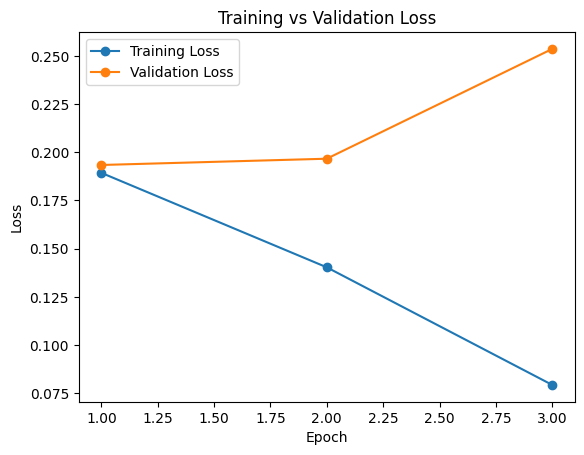

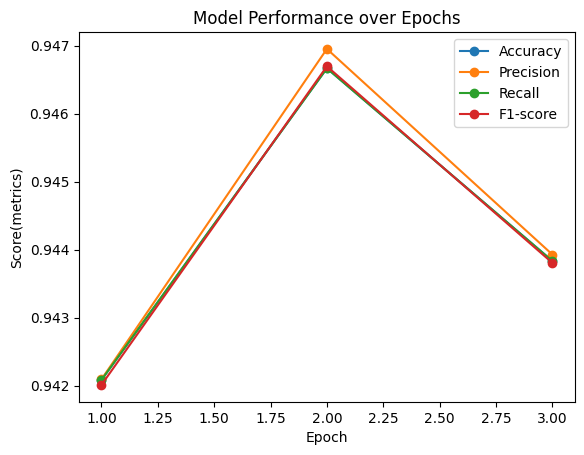

In [18]:
import matplotlib.pyplot as plt

# Données issues de ton tableau de résultats
epochs = [1, 2, 3]

training_loss = [0.189300, 0.140300, 0.079300]
validation_loss = [0.193376, 0.196625, 0.253571]

accuracy = [0.942083, 0.946667, 0.943833]
precision = [0.942092, 0.946952, 0.943928]
recall = [0.942083, 0.946667, 0.943833]
f1 = [0.942010, 0.946696, 0.943805]


# ~~~~~~~~~~~~ GRAPH 1: LOSS ~~~~~~~~~~~~
plt.figure()
plt.plot(epochs , training_loss , marker='o' , label = "Training Loss")
plt.plot(epochs , validation_loss , marker = 'o',label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


# ~~~~~~~~~~~~~ GRAPH 2 : Performance Metrics ~~~~~~~~~~
plt.figure()
plt.plot(epochs,accuracy,marker='o',label="Accuracy")
plt.plot(epochs,precision,marker='o',label = "Precision")
plt.plot(epochs,recall,marker='o',label="Recall")
plt.plot(epochs,f1,marker='o',label="F1-score")
plt.xlabel("Epoch")
plt.ylabel("Score(metrics)")
plt.title("Model Performance over Epochs")
plt.legend()
plt.show()





In [19]:
# Évaluation finale sur le test set
test_results = trainer.evaluate(test_dataset)
print(test_results)


{'eval_loss': 0.19701999425888062, 'eval_accuracy': 0.9442105263157895, 'eval_precision': 0.9444924920511595, 'eval_recall': 0.9442105263157895, 'eval_f1': 0.9442813605826592, 'eval_runtime': 19.397, 'eval_samples_per_second': 391.814, 'eval_steps_per_second': 24.488, 'epoch': 3.0}


In [23]:
# Sauvegarde du modèle

PATH  = "/content/drive/MyDrive/master_s3/NLP/projet_individual"
model.save_pretrained(PATH + "/results/")
tokenizer.save_pretrained(PATH + "/results/")

('/content/drive/MyDrive/master_s3/NLP/projet_individual/results/tokenizer_config.json',
 '/content/drive/MyDrive/master_s3/NLP/projet_individual/results/special_tokens_map.json',
 '/content/drive/MyDrive/master_s3/NLP/projet_individual/results/vocab.txt',
 '/content/drive/MyDrive/master_s3/NLP/projet_individual/results/added_tokens.json',
 '/content/drive/MyDrive/master_s3/NLP/projet_individual/results/tokenizer.json')

In [30]:

ls results/ ## the saved checkpoints

checkpoint-13500/  checkpoint-20250/  checkpoint-6750/


In [32]:

# Create a folder in your Drive

!mkdir -p PATH+"/distilbert_agnews"

# Copy checkpoints to Drive
!cp -r ./results/* PATH+"/distilbert_agnews"

In [33]:
# Create a folder in your Drive

!mkdir -p /content/drive/MyDrive/master_s3/NLP/projet_individual/distilbert_agnews_cp

# Copy checkpoints to Drive
!cp -r ./results/* /content/drive/MyDrive/master_s3/NLP/projet_individual/distilbert_agnews_cp


In [38]:
# Replace with your checkpoint folder path
checkpoint_path = "./results/checkpoint-13500"

model_epoch2 = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint_path)

model_epoch2.eval()  # Important for inference

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [47]:
text = "."

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
with torch.no_grad():
    outputs = model_epoch2(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
print("Predicted category (epoch 2):", label_map[pred])


Predicted category (epoch 2): World
